# CREACIÓN DEL DATAMART ANALÍTICO

Ahora que ya tenemos todos las tablas de interés en la base de datos, vamos a revisar la calidad de los datos en dichas tablas. Así pues, después de aplicar las modificaciones necesarias, las uniremos finalmente para formar el datamart analítico.

Resumiendo, lo que vamos a hacer es:

* Acceder a la base de datos.
* Importar los datos como dataframes de Pandas.
* Realizar la calidad de datos.
* Crear el datamart analítico.
* Guardarlo como una tabla en la base de datos para no tener que repetir este proceso más veces.

## SET UP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlalchemy as sa

#Automcompletar rápido
%config IPCompleter.greedy=True

## IMPORTACION DE DATOS

### Datos internos

Creamos la conexión a la base de datos:

In [2]:
con = sa.create_engine('sqlite:///../Datos/airbnb.db')

Cargamos las tablas:

In [3]:
listings = pd.read_sql('listings', con)
listings_det = pd.read_sql('listings_det', con)

### Datos Externos

En los datos descargados de AirBnb no tenemos el precio de compra de los inmuebles, siendo esta información una de las palancas principales.

Por tanto tenemos que buscar esos datos de forma externa. Para ello, utilizaremos la información que nos proporciona idealista: https://www.idealista.com/sala-de-prensa/informes-precio-vivienda/venta/madrid-comunidad/madrid-provincia/madrid/

Podemos extraerla de forma sencilla con el plugin *instant data scraper* de Chrome, y la guardaremos en la carpeta Datos con el nombre 'precios_idealista.csv'

Cargamos los datos, quitamos el primer registro y seleccionamos solo las columnas de precio y distrito

In [5]:
precio_m2 = pd.read_csv('../Datos/precios_idealista.csv') \
    .loc[1:,['table__cell','icon-elbow']] \
    .rename(columns = {'table__cell':'precio_m2','icon-elbow':'distrito'})
precio_m2

,precio_m2,distrito
1,4.085 €/m2,Arganzuela
2,3.409 €/m2,Barajas
3,2.123 €/m2,Carabanchel
4,4.827 €/m2,Centro
5,5.098 €/m2,Chamartín
6,5.381 €/m2,Chamberí
7,2.940 €/m2,Ciudad Lineal
8,3.568 €/m2,Fuencarral
9,3.871 €/m2,Hortaleza
10,2.267 €/m2,Latina


Limpiamos el precio:

* Quitamos las unidades.
* Quitamos los puntos de separador de miles.
* Lo cambiamos a tipo entero.

In [6]:
precio_m2['precio_m2'] = precio_m2.precio_m2.str.split(expand = True)[0].str.replace('.','',regex=False).astype('int')
precio_m2

,precio_m2,distrito
1,4085,Arganzuela
2,3409,Barajas
3,2123,Carabanchel
4,4827,Centro
5,5098,Chamartín
6,5381,Chamberí
7,2940,Ciudad Lineal
8,3568,Fuencarral
9,3871,Hortaleza
10,2267,Latina


## CALIDAD DE DATOS

### Tabla listings

#### Visión general

In [7]:
listings.head()

,index,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,0,6369,"Rooftop terrace room , ensuite bathroom",13660,Simon,Chamartín,Hispanoamérica,40.45724,-3.67688,Private room,60,1,80,2019-05-14,1.21,2,180,4,None
1,1,21853,Bright and airy room,83531,Abdel,Latina,Cármenes,40.40381,-3.74130,Private room,31,4,33,2018-05-29,0.39,2,364,0,None
2,2,23001,Apartmento Arganzuela- Madrid Rio,82175,Jesus,Arganzuela,Legazpi,40.38840,-3.69511,Entire home/apt,50,15,0,None,NaN,5,222,0,None
3,3,24805,Gran Via Studio Madrid,346366726,A,Centro,Universidad,40.42183,-3.70529,Entire home/apt,92,5,12,2020-03-01,0.51,1,115,2,None
4,4,26825,Single Room whith private Bathroom,114340,Agustina,Arganzuela,Legazpi,40.38975,-3.69018,Private room,26,2,149,2018-05-15,1.65,1,349,0,None


In [8]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18909 entries, 0 to 18908
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           18909 non-null  int64  
 1   id                              18909 non-null  int64  
 2   name                            18906 non-null  object 
 3   host_id                         18909 non-null  int64  
 4   host_name                       18883 non-null  object 
 5   neighbourhood_group             18909 non-null  object 
 6   neighbourhood                   18909 non-null  object 
 7   latitude                        18909 non-null  float64
 8   longitude                       18909 non-null  float64
 9   room_type                       18909 non-null  object 
 10  price                           18909 non-null  int64  
 11  minimum_nights                  18909 non-null  int64  
 12  number_of_reviews               

#### Variables y tipos

Vamos a eliminar aquellas variables que no necesitaremos directamente para nuestros objetivos.

In [9]:
a_eliminar = ['index',
              'host_name',
              'number_of_reviews',
              'last_review',
              'reviews_per_month',
              'number_of_reviews_ltm',
              'license'
             ]

listings.drop(columns = a_eliminar, inplace=True)

listings

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
0,6369,"Rooftop terrace room , ensuite bathroom",13660,Chamartín,Hispanoamérica,40.457240,-3.676880,Private room,60,1,2,180
1,21853,Bright and airy room,83531,Latina,Cármenes,40.403810,-3.741300,Private room,31,4,2,364
2,23001,Apartmento Arganzuela- Madrid Rio,82175,Arganzuela,Legazpi,40.388400,-3.695110,Entire home/apt,50,15,5,222
3,24805,Gran Via Studio Madrid,346366726,Centro,Universidad,40.421830,-3.705290,Entire home/apt,92,5,1,115
4,26825,Single Room whith private Bathroom,114340,Arganzuela,Legazpi,40.389750,-3.690180,Private room,26,2,1,349
...,...,...,...,...,...,...,...,...,...,...,...,...
18904,52182264,Enormous Private Room in 12-Bedroom Unit - los...,378060726,Centro,Justicia,40.424384,-3.691216,Private room,29,1,87,358
18905,52182273,Stunning Private Room in 11-Bedroom Unit - los...,378060726,Centro,Justicia,40.424447,-3.691309,Private room,29,1,87,358
18906,52182303,Classic Private Room in 7-Bedroom Unit - los 3...,378060726,Centro,Justicia,40.424989,-3.691783,Private room,29,1,87,358
18907,52182321,Elegant Private Room in 12-Bedroom Unit - los ...,378060726,Salamanca,Recoletos,40.424352,-3.690211,Private room,29,1,87,358


Revisamos los tipos de variable

In [10]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18909 entries, 0 to 18908
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              18909 non-null  int64  
 1   name                            18906 non-null  object 
 2   host_id                         18909 non-null  int64  
 3   neighbourhood_group             18909 non-null  object 
 4   neighbourhood                   18909 non-null  object 
 5   latitude                        18909 non-null  float64
 6   longitude                       18909 non-null  float64
 7   room_type                       18909 non-null  object 
 8   price                           18909 non-null  int64  
 9   minimum_nights                  18909 non-null  int64  
 10  calculated_host_listings_count  18909 non-null  int64  
 11  availability_365                18909 non-null  int64  
dtypes: float64(2), int64(6), object(

Pasamos algunas de tipo objeto (neighbourhood_group, neighbourhood, room_type) a categóricas para mayor eficiencia.

In [11]:
for variable in ['neighbourhood_group','neighbourhood','room_type']:
    listings[variable] = listings[variable].astype('category')

Comprobamos

In [12]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18909 entries, 0 to 18908
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id                              18909 non-null  int64   
 1   name                            18906 non-null  object  
 2   host_id                         18909 non-null  int64   
 3   neighbourhood_group             18909 non-null  category
 4   neighbourhood                   18909 non-null  category
 5   latitude                        18909 non-null  float64 
 6   longitude                       18909 non-null  float64 
 7   room_type                       18909 non-null  category
 8   price                           18909 non-null  int64   
 9   minimum_nights                  18909 non-null  int64   
 10  calculated_host_listings_count  18909 non-null  int64   
 11  availability_365                18909 non-null  int64   
dtypes: category(3), fl

#### Análisis de nulos

Por la columna Non-null del info() vemos que solo name tiene 3 nulos.

Los revisamos pero vemos que no supone un problema, así que los dejamos.

In [13]:
listings[listings.name.isna()]

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
1538,7164589,None,37525983,Centro,Palacio,40.41458,-3.71422,Private room,30,1,1,0
2394,11687495,None,48387429,San Blas - Canillejas,Simancas,40.43765,-3.62672,Entire home/apt,50,1,1,0
2842,13585476,None,20922102,Centro,Universidad,40.42718,-3.71144,Entire home/apt,65,3,1,0


#### Análisis de duplicados

Comprobamos si hay algún registro duplicado

In [14]:
listings.duplicated().sum()

0

#### Análisis de variables categóricas

Vamos a analizar los valores y las frecuencias de las variables categóricas

In [15]:
listings.neighbourhood_group.value_counts()

neighbourhood_group
Centro                   8433
Salamanca                1267
Chamberí                 1148
Arganzuela               1070
Tetuán                    811
Carabanchel               669
Retiro                    656
Ciudad Lineal             601
Chamartín                 562
Latina                    547
Puente de Vallecas        542
Moncloa - Aravaca         535
San Blas - Canillejas     485
Hortaleza                 374
Fuencarral - El Pardo     294
Usera                     275
Villaverde                186
Barajas                   147
Moratalaz                 131
Villa de Vallecas         105
Vicálvaro                  71
Name: count, dtype: int64

In [16]:
listings.neighbourhood.value_counts()

neighbourhood
Embajadores    2255
Universidad    1772
Palacio        1533
Sol            1126
Justicia        910
               ... 
El Plantío        5
Valdemarín        4
El Pardo          3
Horcajo           2
Atalaya           1
Name: count, Length: 128, dtype: int64

In [17]:
listings.room_type.value_counts()

room_type
Entire home/apt    11098
Private room        7390
Shared room          258
Hotel room           163
Name: count, dtype: int64

Vemos que hay habitaciones de hotel. Esta temática no está dentro de nuestro modelo de negocio, así que eliminamos estos registros.

In [19]:
listings = listings.loc[listings.room_type != 'Hotel room']

In [20]:
listings.room_type.value_counts()

room_type
Entire home/apt    11098
Private room        7390
Shared room          258
Hotel room             0
Name: count, dtype: int64

#### Análisis de variables numéricas

De las variables numéricas tiene sentido analizar desde price hasta availability_365, es decir desde las posiciones de columnas de la 8 a la 11:

In [21]:
listings.iloc[:,8:12].describe().T

,count,mean,std,min,25%,50%,75%,max
price,18746.0,129.271365,432.384680,8.0,36.0,64.0,105.0,9999.0
minimum_nights,18746.0,7.295850,35.430022,1.0,1.0,2.0,3.0,1125.0
calculated_host_listings_count,18746.0,10.731676,26.429455,1.0,1.0,2.0,6.0,194.0
availability_365,18746.0,153.761656,140.363063,0.0,0.0,113.0,310.0,365.0


Conclusiones:

* En el precio hay que revisar mínimos y máximos.
* En minimum_nights hay que revisar los máximos.
* En calculated_host_listings_count hay que revisar los máximos.

Revisamos mínimos y máximos en el precio

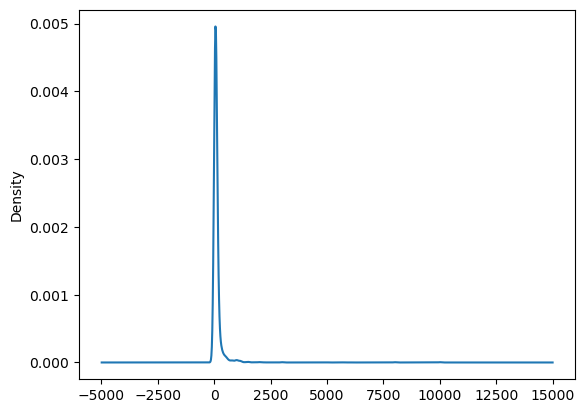

In [36]:
listings.price.plot.kde();

Revisamos los máximos

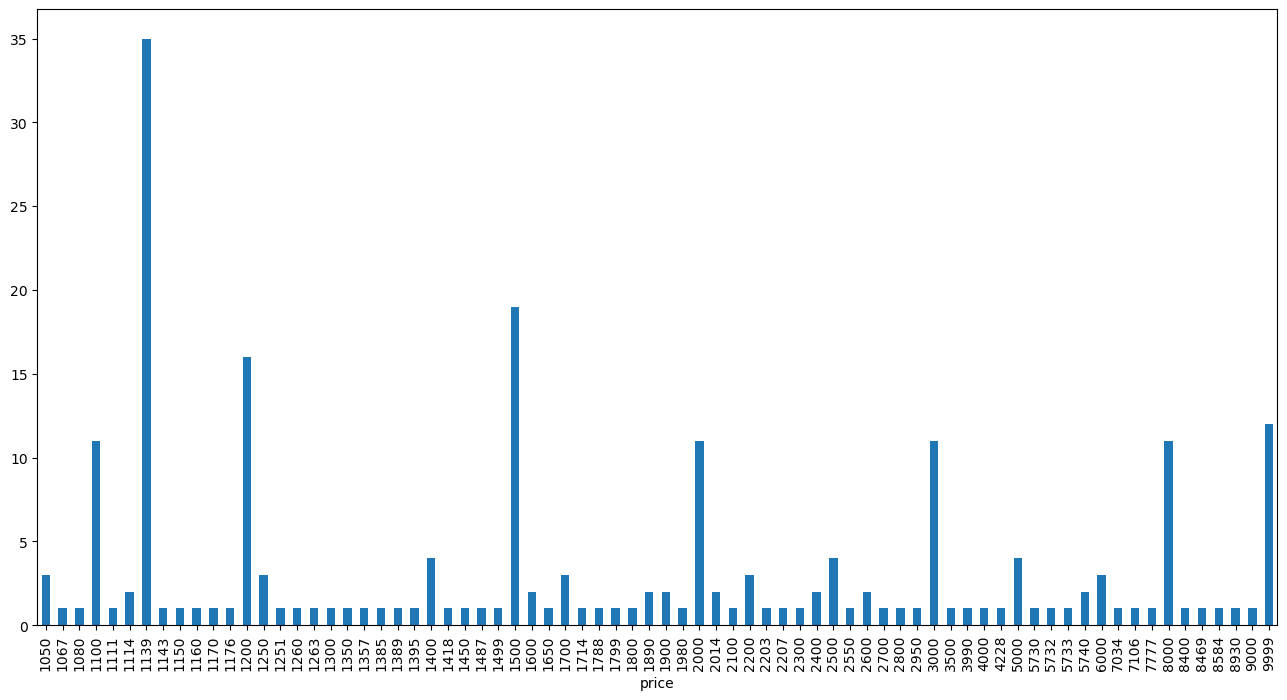

In [37]:
plt.figure(figsize=(16,8))
listings.price.loc[listings.price > 1000].value_counts().sort_index().plot.bar()
plt.xticks(size = 10);

Conclusión: 
    
* El valor 9999 normalmente suele ser una forma de imputar nulos, pero en este caso su frecuencia no está muy lejos de otros valores que pueden ser válidos, como el 8000, así que no lo vamos a tocar.

Revisamos los valores cercanos a cero:

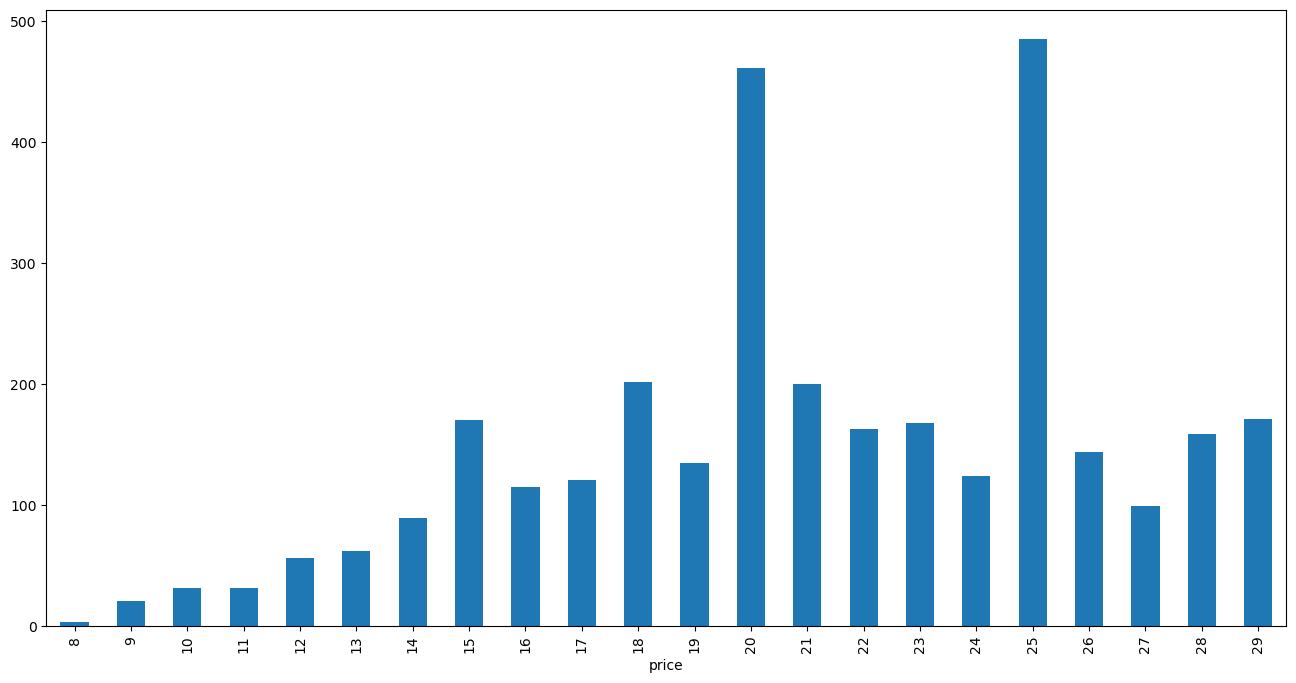

In [38]:
plt.figure(figsize=(16,8))
listings.price.loc[listings.price < 30].value_counts().sort_index().plot.bar()
plt.xticks(size = 10);

Conclusión: 
    
* Hay un pico en 20 euros, y parece que por debajo de esa cantidad sería difícil obtener rentabilidad, así que vamos a descartar los inmuebles que se alquilan por debajo de 20 euros.

In [39]:
listings = listings.loc[listings.price > 19]
listings

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
0,6369,"Rooftop terrace room , ensuite bathroom",13660,Chamartín,Hispanoamérica,40.457240,-3.676880,Private room,60,1,2,180
1,21853,Bright and airy room,83531,Latina,Cármenes,40.403810,-3.741300,Private room,31,4,2,364
2,23001,Apartmento Arganzuela- Madrid Rio,82175,Arganzuela,Legazpi,40.388400,-3.695110,Entire home/apt,50,15,5,222
3,24805,Gran Via Studio Madrid,346366726,Centro,Universidad,40.421830,-3.705290,Entire home/apt,92,5,1,115
4,26825,Single Room whith private Bathroom,114340,Arganzuela,Legazpi,40.389750,-3.690180,Private room,26,2,1,349
...,...,...,...,...,...,...,...,...,...,...,...,...
18904,52182264,Enormous Private Room in 12-Bedroom Unit - los...,378060726,Centro,Justicia,40.424384,-3.691216,Private room,29,1,87,358
18905,52182273,Stunning Private Room in 11-Bedroom Unit - los...,378060726,Centro,Justicia,40.424447,-3.691309,Private room,29,1,87,358
18906,52182303,Classic Private Room in 7-Bedroom Unit - los 3...,378060726,Centro,Justicia,40.424989,-3.691783,Private room,29,1,87,358
18907,52182321,Elegant Private Room in 12-Bedroom Unit - los ...,378060726,Salamanca,Recoletos,40.424352,-3.690211,Private room,29,1,87,358


Analizamos minimum_nights:

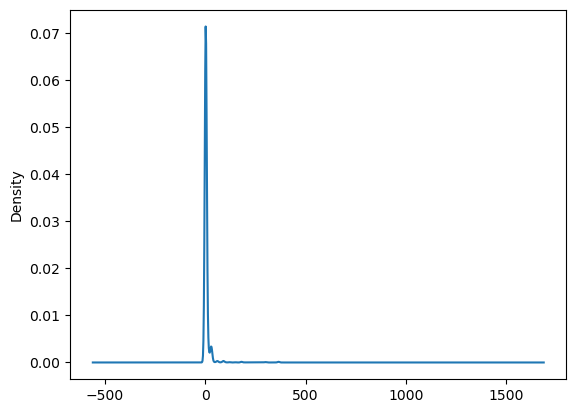

In [42]:
listings.minimum_nights.plot.kde();

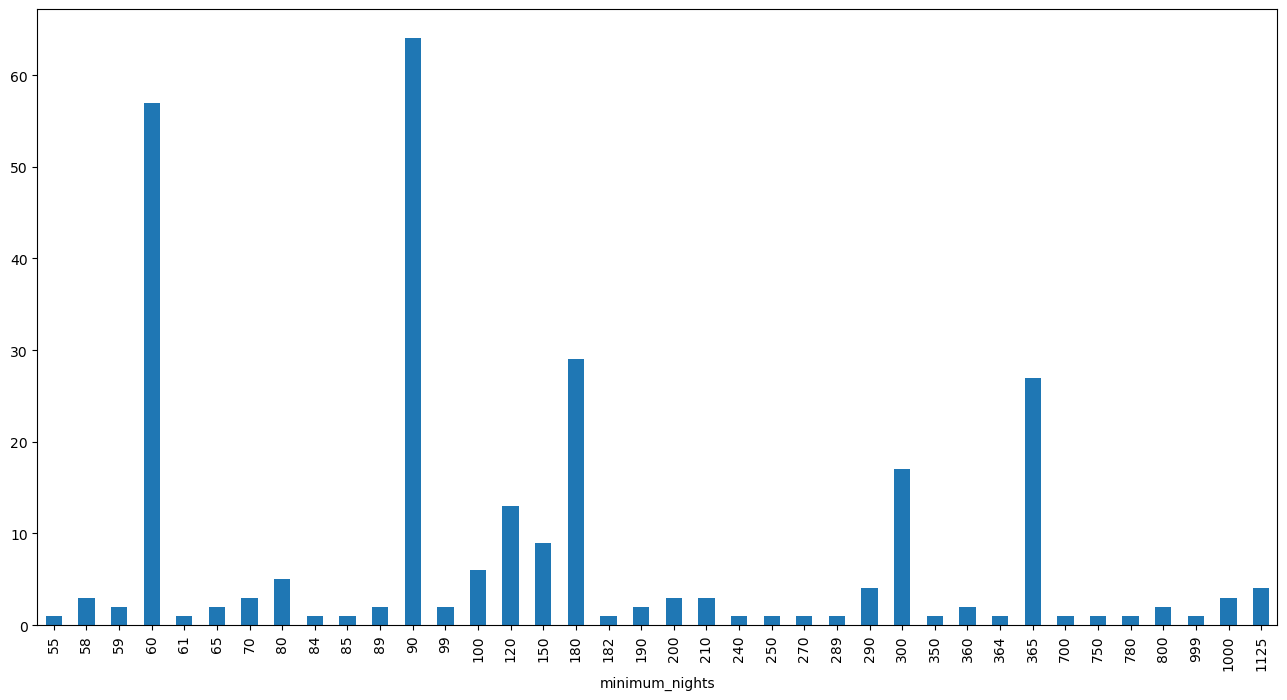

In [48]:
plt.figure(figsize=(16,8))
listings.minimum_nights.loc[listings.minimum_nights > 50].value_counts().sort_index().plot.bar()
plt.xticks(size = 10);

Vemos cosas interesantes, como que mucha gente alquila los inmuebles para dos, tres meses e incluso medio o un año entero. También vemos que poca gente lo alquila más de ese tiempo. El grueso del análisis se centra por debajo del mes, pero dejaremos todos los datos en este caso.

Analizamos calculated_host_listings_count:

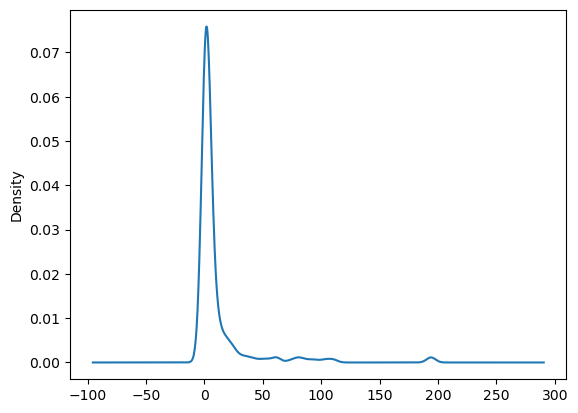

In [49]:
listings.calculated_host_listings_count.plot.kde();

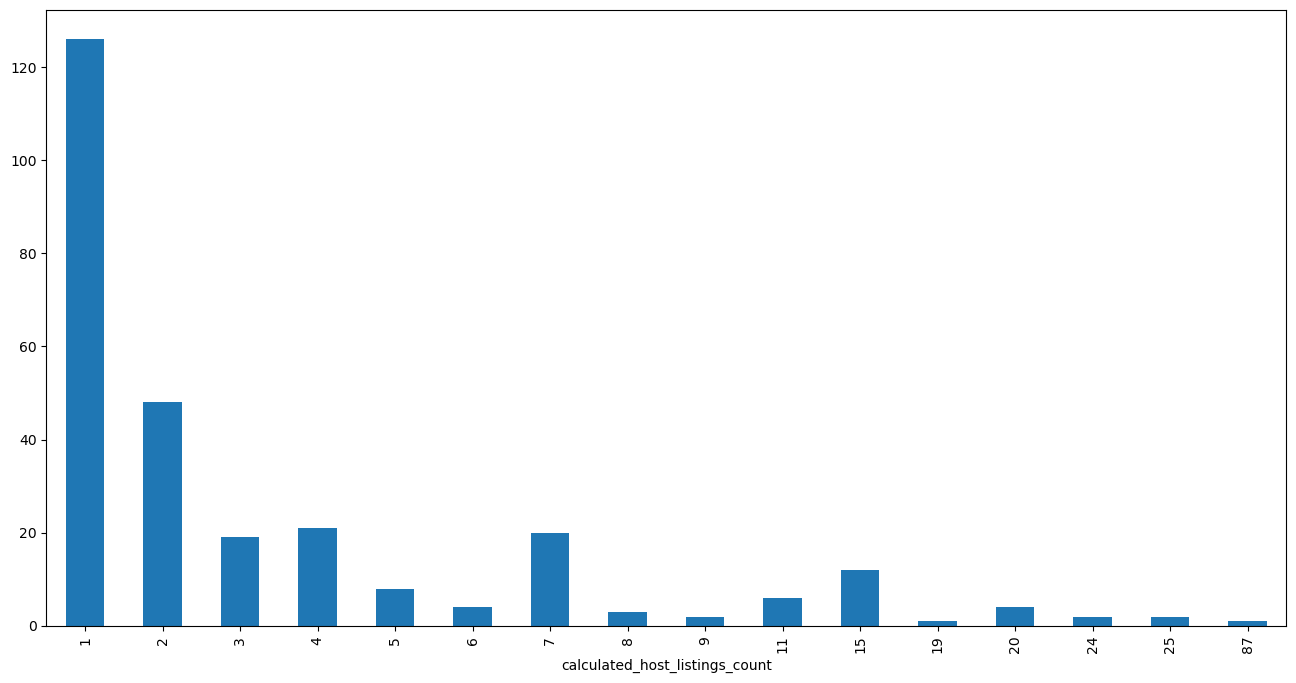

In [50]:
plt.figure(figsize=(16,8))
listings.calculated_host_listings_count[listings.minimum_nights > 50].value_counts().sort_index().plot.bar()
plt.xticks(size = 10);

No vemos nada raro en esta variable, así que la dejaremos como está.

### Tabla listings_det

#### Visión general

In [51]:
listings_det.head()

,index,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,0,6369,https://www.airbnb.com/rooms/6369,20210910193531,2021-09-11,"Rooftop terrace room , ensuite bathroom",Excellent connection with the AIRPORT and EXHI...,None,https://a0.muscache.com/pictures/683224/4cc318...,13660,...,4.89,4.77,4.85,None,f,2,0,2,0,1.21
1,1,21853,https://www.airbnb.com/rooms/21853,20210910193531,2021-09-11,Bright and airy room,We have a quiet and sunny room with a good vie...,We live in a leafy neighbourhood with plenty o...,https://a0.muscache.com/pictures/68483181/87bc...,83531,...,4.82,4.21,4.67,None,f,2,0,2,0,0.39
2,2,23001,https://www.airbnb.com/rooms/23001,20210910193531,2021-09-11,Apartmento Arganzuela- Madrid Rio,"Apartamento de tres dormitorios dobles, gran s...","Barrio Arganzuela, junto a Madrid Rio, zonas c...",https://a0.muscache.com/pictures/58e6a770-509c...,82175,...,NaN,NaN,NaN,None,f,5,4,1,0,NaN
3,3,24805,https://www.airbnb.com/rooms/24805,20210910193531,2021-09-11,Gran Via Studio Madrid,"Studio located 50 meters from Gran Via, next t...","The area is next to the Gran Via, so people li...",https://a0.muscache.com/pictures/miso/Hosting-...,346366726,...,5.00,5.00,4.83,None,f,1,1,0,0,0.51
4,4,26825,https://www.airbnb.com/rooms/26825,20210910193531,2021-09-11,Single Room whith private Bathroom,Nice and cozy roon for one person with a priva...,"Es un barrio muy tranquilo, en una zona de Mad...",https://a0.muscache.com/pictures/149358/218d5b...,114340,...,4.71,4.70,4.72,None,f,1,0,1,0,1.65


In [52]:
listings_det.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18909 entries, 0 to 18908
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   index                                         18909 non-null  int64  
 1   id                                            18909 non-null  int64  
 2   listing_url                                   18909 non-null  object 
 3   scrape_id                                     18909 non-null  int64  
 4   last_scraped                                  18909 non-null  object 
 5   name                                          18906 non-null  object 
 6   description                                   17854 non-null  object 
 7   neighborhood_overview                         10997 non-null  object 
 8   picture_url                                   18908 non-null  object 
 9   host_id                                       18909 non-null 

#### Variables y tipos

Vamos a seleccionar solo aquellas variables que nos aporten información relevante para nuestros objetivos:

In [53]:
a_incluir = ['id',
              'description',
              'host_is_superhost',
              'accommodates',
              'bathrooms',
              'bedrooms',
              'beds',
              'number_of_reviews',
              'review_scores_rating',
              'review_scores_communication',
              'review_scores_location'
             ]

listings_det = listings_det.loc[:,a_incluir]

listings_det

,id,description,host_is_superhost,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location
0,6369,Excellent connection with the AIRPORT and EXHI...,t,2,NaN,1.0,1.0,80,4.87,4.89,4.77
1,21853,We have a quiet and sunny room with a good vie...,f,1,NaN,1.0,1.0,33,4.58,4.82,4.21
2,23001,"Apartamento de tres dormitorios dobles, gran s...",f,6,NaN,3.0,5.0,0,NaN,NaN,NaN
3,24805,"Studio located 50 meters from Gran Via, next t...",f,3,NaN,NaN,1.0,12,4.92,5.00,5.00
4,26825,Nice and cozy roon for one person with a priva...,f,1,NaN,1.0,1.0,149,4.68,4.71,4.70
...,...,...,...,...,...,...,...,...,...,...,...
18904,52182264,ROOM - 8 sqm. • 1st Floor <br /> <br />cozy ro...,f,1,NaN,1.0,0.0,0,NaN,NaN,NaN
18905,52182273,ROOM - 10 sqm. • 4th Floor <br /> <br />cozy r...,f,1,NaN,1.0,0.0,0,NaN,NaN,NaN
18906,52182303,ROOM <br /> <br />cozy room in madrid centro i...,f,1,NaN,1.0,0.0,0,NaN,NaN,NaN
18907,52182321,ROOM -9 sqm. • 1st Floor <br /> <br />cozy roo...,f,1,NaN,1.0,0.0,0,NaN,NaN,NaN


Analizamos los tipos:

In [54]:
listings_det.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18909 entries, 0 to 18908
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           18909 non-null  int64  
 1   description                  17854 non-null  object 
 2   host_is_superhost            18883 non-null  object 
 3   accommodates                 18909 non-null  int64  
 4   bathrooms                    0 non-null      float64
 5   bedrooms                     17475 non-null  float64
 6   beds                         18568 non-null  float64
 7   number_of_reviews            18909 non-null  int64  
 8   review_scores_rating         13877 non-null  float64
 9   review_scores_communication  13640 non-null  float64
 10  review_scores_location       13637 non-null  float64
dtypes: float64(6), int64(3), object(2)
memory usage: 1.6+ MB


Conclusión: pasar host_is_superhost a categórica.

In [55]:
listings_det['host_is_superhost'] = listings_det['host_is_superhost'].astype('category')
    
listings_det.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18909 entries, 0 to 18908
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   id                           18909 non-null  int64   
 1   description                  17854 non-null  object  
 2   host_is_superhost            18883 non-null  category
 3   accommodates                 18909 non-null  int64   
 4   bathrooms                    0 non-null      float64 
 5   bedrooms                     17475 non-null  float64 
 6   beds                         18568 non-null  float64 
 7   number_of_reviews            18909 non-null  int64   
 8   review_scores_rating         13877 non-null  float64 
 9   review_scores_communication  13640 non-null  float64 
 10  review_scores_location       13637 non-null  float64 
dtypes: category(1), float64(6), int64(3), object(1)
memory usage: 1.5+ MB


#### Análisis de nulos

In [56]:
listings_det.isna().sum()

id                                 0
description                     1055
host_is_superhost                 26
accommodates                       0
bathrooms                      18909
bedrooms                        1434
beds                             341
number_of_reviews                  0
review_scores_rating            5032
review_scores_communication     5269
review_scores_location          5272
dtype: int64

Conclusiones:

* bathrooms está totalmente lleno de nulos, por tanto la eliminamos.
* description no pasa nada porque tenga nulos, así que la dejamos.
* host_is_superhost tiene muy pocos nulos y no es una variables super relevante, así que la dejamos.
* beds: podemos intentar imputarla a partir de accomodates.
* bedrooms sí es una variable importante (la necesitamos para estimar el precio de compra del inmueble), podemos intentar imputar los nulos a través de **proxies** como accomodates o beds.

Vamos a ver si podemos hacer una imputación de beds a partir del número de personas que se pueden acomodar.

In [57]:
pd.crosstab(listings_det.beds, listings_det.accommodates)

accommodates,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
beds,,,,,,,,,,,,,,,,
0.0,222,259,41,68,15,12,5,3,0,2,0,0,0,0,0,1
1.0,2765,4911,399,639,14,9,0,3,0,2,0,0,0,0,0,9
2.0,120,1110,1016,2277,125,148,3,3,0,1,0,0,1,0,0,1
3.0,18,75,231,925,395,582,18,26,1,1,0,0,0,0,0,0
4.0,20,28,32,216,214,498,73,92,3,9,0,1,0,0,0,0
5.0,2,5,6,20,42,178,75,94,9,30,2,2,0,1,0,0
6.0,14,9,2,5,7,62,21,61,9,18,4,8,2,0,0,0
7.0,0,1,0,2,2,6,10,19,8,17,2,6,1,4,0,0
8.0,3,2,0,0,3,2,0,21,3,18,2,9,2,2,1,0


Parece que sí podríamos hacer una asignación mas o menos directa. Leyendo la matriz en vertical vemos que:

* Una o dos personas se suelen corresponder con una cama
* Tres o cuatro personas se suelen corresponder con dos camas.
* Cinco o seis personas se suelen corresponder con tres camas.
* A más de 6 personas le vamos a poner cuatro camas.

Repasamos el número de nulos y la frecuencia de cada valor

In [58]:
listings_det['beds'].value_counts(dropna = False)

beds
1.0     8751
2.0     4805
3.0     2272
4.0     1186
0.0      628
5.0      466
NaN      341
6.0      222
7.0       78
8.0       68
10.0      39
9.0       20
14.0       6
11.0       6
12.0       5
16.0       5
13.0       4
18.0       2
17.0       2
15.0       1
23.0       1
24.0       1
Name: count, dtype: int64

Creamos una función para imputar los nulos de beds en base a accommodates:

In [59]:
def imputar_nulos(registro):
    #Lista de condiciones
    condiciones = [(registro.accommodates <= 2),
               (registro.accommodates > 2) & (registro.accommodates <= 4),
               (registro.accommodates > 4) & (registro.accommodates <= 6),
               (registro.accommodates > 6)]

    #Lista de resultados
    resultados = [1,2,3,4]
    
    #Salida
    return(np.select(condiciones,resultados, default = -999))

#Imputación
listings_det.loc[listings_det.beds.isna(),'beds'] = listings_det.loc[listings_det.beds.isna()].apply(imputar_nulos, axis = 1).astype('float64')


Comprobamos:

In [60]:
listings_det.beds.value_counts(dropna = False)

beds
1.0     9061
2.0     4828
3.0     2276
4.0     1190
0.0      628
5.0      466
6.0      222
7.0       78
8.0       68
10.0      39
9.0       20
14.0       6
11.0       6
12.0       5
16.0       5
13.0       4
18.0       2
17.0       2
15.0       1
23.0       1
24.0       1
Name: count, dtype: int64

Ahora vamos a ver si podemos hacer una imputación de bedrooms.

Empezamos por cruzar el número de habitaciones con el número de personas que se pueden acomodar.

In [61]:
pd.crosstab(listings_det.bedrooms, listings_det.accommodates)

accommodates,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
bedrooms,,,,,,,,,,,,,,,,
1.0,3009,5569,1141,2265,111,81,4,14,0,7,0,0,0,0,0,11
2.0,74,173,348,1560,444,852,51,48,4,6,1,0,0,1,0,0
3.0,21,22,45,104,220,509,106,158,7,20,4,13,1,2,1,0
4.0,16,21,1,12,18,38,34,96,10,39,2,15,5,2,0,2
5.0,9,6,0,0,4,3,4,6,9,34,3,8,1,3,3,12
6.0,3,3,0,0,0,1,0,1,3,4,2,1,1,1,2,2
7.0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,1,6
8.0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,4
9.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2


No parece muy fiable.

Vamos a contrastarlo con el número de camas.

In [62]:
pd.crosstab(listings_det.bedrooms, listings_det.beds, dropna=False)

beds,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,23.0,24.0
bedrooms,,,,,,,,,,,,,,,,,,,,,
1.0,451,8038,3039,459,139,15,36,1,13,1,...,0,1,0,1,0,0,0,0,0,0
2.0,65,108,1372,1329,532,110,33,7,5,0,...,0,0,0,0,0,0,0,1,0,0
3.0,7,28,22,414,393,242,80,25,11,7,...,2,0,0,0,0,0,0,0,0,0
4.0,6,23,3,7,95,63,56,27,19,6,...,2,2,0,0,0,0,0,0,0,0
5.0,1,14,0,0,2,26,10,16,17,2,...,1,1,2,1,0,2,0,1,0,0
6.0,2,4,0,0,0,0,6,0,2,3,...,0,1,1,0,0,1,1,0,0,0
7.0,0,0,1,0,1,0,0,1,1,0,...,0,0,1,3,1,1,1,0,0,0
8.0,0,3,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
9.0,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


Aquí sí podríamos hacer una asignación más directa. Leyendo la matriz en vertical vemos que:

* Cero, una o dos camas se suele corresponder con una habitación.
* Tres o cuatro camas se suele corresponder con dos habitaciones.
* Cinco o seis camas se suele corresponder con tres habitaciones.
* A más camas le vamos a poner cuatro habitaciones.

Vamos a modificar la función que habíamos creado para imputar los nulos de bedrooms a partir de beds.

Primero hacemos el conteo de bedrooms:

In [63]:
listings_det.bedrooms.value_counts(dropna = False)

bedrooms
1.0     12212
2.0      3562
NaN      1434
3.0      1233
4.0       311
5.0       105
6.0        24
7.0        11
8.0         7
9.0         3
10.0        3
14.0        2
15.0        1
18.0        1
Name: count, dtype: int64

Ejecutamos la función actualizada:

In [64]:
def imputar_nulos(registro):
    #Lista de condiciones
    condiciones = [(registro.beds <= 2),
               (registro.beds > 2) & (registro.beds <= 4),
               (registro.beds > 4) & (registro.beds <= 6),
               (registro.beds > 6)]

    #Lista de resultados
    resultados = [1,2,3,4]
    
    #Salida
    return(np.select(condiciones,resultados, default = -999))

#Imputación
listings_det.loc[listings_det.bedrooms.isna(),'bedrooms'] = listings_det.loc[listings_det.bedrooms.isna()].apply(imputar_nulos, axis = 1).astype('float64')

Comprobamos:

In [65]:
listings_det.bedrooms.value_counts(dropna = False)

bedrooms
1.0     13540
2.0      3657
3.0      1244
4.0       311
5.0       105
6.0        24
7.0        11
8.0         7
9.0         3
10.0        3
14.0        2
15.0        1
18.0        1
Name: count, dtype: int64

Por último vamos a eliminar bathrooms:

In [66]:
listings_det.drop(columns = 'bathrooms', inplace = True)
listings_det

,id,description,host_is_superhost,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location
0,6369,Excellent connection with the AIRPORT and EXHI...,t,2,1.0,1.0,80,4.87,4.89,4.77
1,21853,We have a quiet and sunny room with a good vie...,f,1,1.0,1.0,33,4.58,4.82,4.21
2,23001,"Apartamento de tres dormitorios dobles, gran s...",f,6,3.0,5.0,0,NaN,NaN,NaN
3,24805,"Studio located 50 meters from Gran Via, next t...",f,3,1.0,1.0,12,4.92,5.00,5.00
4,26825,Nice and cozy roon for one person with a priva...,f,1,1.0,1.0,149,4.68,4.71,4.70
...,...,...,...,...,...,...,...,...,...,...
18904,52182264,ROOM - 8 sqm. • 1st Floor <br /> <br />cozy ro...,f,1,1.0,0.0,0,NaN,NaN,NaN
18905,52182273,ROOM - 10 sqm. • 4th Floor <br /> <br />cozy r...,f,1,1.0,0.0,0,NaN,NaN,NaN
18906,52182303,ROOM <br /> <br />cozy room in madrid centro i...,f,1,1.0,0.0,0,NaN,NaN,NaN
18907,52182321,ROOM -9 sqm. • 1st Floor <br /> <br />cozy roo...,f,1,1.0,0.0,0,NaN,NaN,NaN


#### Análisis de duplicados

Comprobamos si hay algún registro duplicado:

In [67]:
listings_det.duplicated().sum()

0

In [68]:
listings_det.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18909 entries, 0 to 18908
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   id                           18909 non-null  int64   
 1   description                  17854 non-null  object  
 2   host_is_superhost            18883 non-null  category
 3   accommodates                 18909 non-null  int64   
 4   bedrooms                     18909 non-null  float64 
 5   beds                         18909 non-null  float64 
 6   number_of_reviews            18909 non-null  int64   
 7   review_scores_rating         13877 non-null  float64 
 8   review_scores_communication  13640 non-null  float64 
 9   review_scores_location       13637 non-null  float64 
dtypes: category(1), float64(5), int64(3), object(1)
memory usage: 1.3+ MB


#### Análisis de variables categóricas

Vamos a analizar los valores y las frecuencias de las variables categóricas:

In [69]:
listings_det.host_is_superhost.value_counts()

host_is_superhost
f    15423
t     3460
Name: count, dtype: int64

No hay nada relevante en esta variable para nuestro objetivo.

#### Análisis de variables numéricas

In [71]:
listings_det.describe(include = 'number').T

,count,mean,std,min,25%,50%,75%,max
id,18909.0,3.055841e+07,1.448889e+07,6369.0,19305558.00,33537761.00,42555334.00,52182334.0
accommodates,18909.0,3.094928e+00,1.963715e+00,0.0,2.00,2.00,4.00,16.0
bedrooms,18909.0,1.414670e+00,8.116969e-01,1.0,1.00,1.00,2.00,18.0
beds,18909.0,1.909197e+00,1.444317e+00,0.0,1.00,1.00,2.00,24.0
number_of_reviews,18909.0,3.270612e+01,6.524996e+01,0.0,0.00,5.00,32.00,744.0
review_scores_rating,13877.0,4.549404e+00,7.834379e-01,0.0,4.50,4.75,4.94,5.0
review_scores_communication,13640.0,4.776612e+00,4.632929e-01,1.0,4.75,4.92,5.00,5.0
review_scores_location,13637.0,4.788151e+00,3.774844e-01,1.0,4.73,4.92,5.00,5.0


No vemos nada extraño.

En este punto ya hemos detectado y corregido los principales problemas de calidad de datos así que pasamos a crear el datamart analítico integrando nuestras tablas.

## DATAMART ANALITICO

Tenemos 2 tablas principales:

* listings
* listings_det

Vamos a unirlas a través del indicador clave *id*, usando la tabla de listings como base pues es la que tiene los registros editados.

In [72]:
df = pd.merge(left = listings, right = listings_det, how = 'left', on = 'id')
df

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,...,availability_365,description,host_is_superhost,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location
0,6369,"Rooftop terrace room , ensuite bathroom",13660,Chamartín,Hispanoamérica,40.457240,-3.676880,Private room,60,1,...,180,Excellent connection with the AIRPORT and EXHI...,t,2,1.0,1.0,80,4.87,4.89,4.77
1,21853,Bright and airy room,83531,Latina,Cármenes,40.403810,-3.741300,Private room,31,4,...,364,We have a quiet and sunny room with a good vie...,f,1,1.0,1.0,33,4.58,4.82,4.21
2,23001,Apartmento Arganzuela- Madrid Rio,82175,Arganzuela,Legazpi,40.388400,-3.695110,Entire home/apt,50,15,...,222,"Apartamento de tres dormitorios dobles, gran s...",f,6,3.0,5.0,0,NaN,NaN,NaN
3,24805,Gran Via Studio Madrid,346366726,Centro,Universidad,40.421830,-3.705290,Entire home/apt,92,5,...,115,"Studio located 50 meters from Gran Via, next t...",f,3,1.0,1.0,12,4.92,5.00,5.00
4,26825,Single Room whith private Bathroom,114340,Arganzuela,Legazpi,40.389750,-3.690180,Private room,26,2,...,349,Nice and cozy roon for one person with a priva...,f,1,1.0,1.0,149,4.68,4.71,4.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17705,52182264,Enormous Private Room in 12-Bedroom Unit - los...,378060726,Centro,Justicia,40.424384,-3.691216,Private room,29,1,...,358,ROOM - 8 sqm. • 1st Floor <br /> <br />cozy ro...,f,1,1.0,0.0,0,NaN,NaN,NaN
17706,52182273,Stunning Private Room in 11-Bedroom Unit - los...,378060726,Centro,Justicia,40.424447,-3.691309,Private room,29,1,...,358,ROOM - 10 sqm. • 4th Floor <br /> <br />cozy r...,f,1,1.0,0.0,0,NaN,NaN,NaN
17707,52182303,Classic Private Room in 7-Bedroom Unit - los 3...,378060726,Centro,Justicia,40.424989,-3.691783,Private room,29,1,...,358,ROOM <br /> <br />cozy room in madrid centro i...,f,1,1.0,0.0,0,NaN,NaN,NaN
17708,52182321,Elegant Private Room in 12-Bedroom Unit - los ...,378060726,Salamanca,Recoletos,40.424352,-3.690211,Private room,29,1,...,358,ROOM -9 sqm. • 1st Floor <br /> <br />cozy roo...,f,1,1.0,0.0,0,NaN,NaN,NaN


Ahora vamos a ver cómo podemos incorporar la información externa del precio por metro cuadrado.

Para ello lo primero es analizar los valores de la variable distrito en ambas tablas, ya que necesitan coincidir para que podamos cruzarlos.

En df la variable es categórica, así que para sacar los niveles tenemos que usar .categories

In [73]:
distritos1 = pd.Series(df.neighbourhood_group.unique().categories).sort_values()
distritos1

0                Arganzuela
1                   Barajas
2               Carabanchel
3                    Centro
4                 Chamartín
5                  Chamberí
6             Ciudad Lineal
7     Fuencarral - El Pardo
8                 Hortaleza
9                    Latina
10        Moncloa - Aravaca
11                Moratalaz
12       Puente de Vallecas
13                   Retiro
14                Salamanca
15    San Blas - Canillejas
16                   Tetuán
17                    Usera
18                Vicálvaro
19        Villa de Vallecas
20               Villaverde
dtype: object

In [74]:
distritos2 = precio_m2.distrito
distritos2

1             Arganzuela
2                Barajas
3            Carabanchel
4                 Centro
5              Chamartín
6               Chamberí
7          Ciudad Lineal
8             Fuencarral
9              Hortaleza
10                Latina
11               Moncloa
12             Moratalaz
13    Puente de Vallecas
14                Retiro
15             Salamanca
16              San Blas
17                Tetuán
18                 Usera
19             Vicálvaro
20     Villa de Vallecas
21            Villaverde
Name: distrito, dtype: object

Comparando parece todo igual excepto:

* Fuencarral - El Pardo.
* Moncloa - Aravaca.
* San Blas - Canillejas.

Por tanto vamos a reemplazar estos valores en precio_m2 para que sean iguales a los de df y podamos cruzarlos:

In [75]:
precio_m2.distrito = precio_m2.distrito.map({'Fuencarral':'Fuencarral - El Pardo',
                        'Moncloa':'Moncloa - Aravaca',
                        'San Blas':'San Blas - Canillejas'}) \
                    .fillna(precio_m2.distrito)

precio_m2

,precio_m2,distrito
1,4085,Arganzuela
2,3409,Barajas
3,2123,Carabanchel
4,4827,Centro
5,5098,Chamartín
6,5381,Chamberí
7,2940,Ciudad Lineal
8,3568,Fuencarral - El Pardo
9,3871,Hortaleza
10,2267,Latina


Ahora sí que ya podemos cruzarlos, usando como base df:

In [76]:
df = pd.merge(left = df, right = precio_m2, how = 'left', left_on='neighbourhood_group', right_on='distrito')
df

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,...,host_is_superhost,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location,precio_m2,distrito
0,6369,"Rooftop terrace room , ensuite bathroom",13660,Chamartín,Hispanoamérica,40.457240,-3.676880,Private room,60,1,...,t,2,1.0,1.0,80,4.87,4.89,4.77,5098,Chamartín
1,21853,Bright and airy room,83531,Latina,Cármenes,40.403810,-3.741300,Private room,31,4,...,f,1,1.0,1.0,33,4.58,4.82,4.21,2267,Latina
2,23001,Apartmento Arganzuela- Madrid Rio,82175,Arganzuela,Legazpi,40.388400,-3.695110,Entire home/apt,50,15,...,f,6,3.0,5.0,0,NaN,NaN,NaN,4085,Arganzuela
3,24805,Gran Via Studio Madrid,346366726,Centro,Universidad,40.421830,-3.705290,Entire home/apt,92,5,...,f,3,1.0,1.0,12,4.92,5.00,5.00,4827,Centro
4,26825,Single Room whith private Bathroom,114340,Arganzuela,Legazpi,40.389750,-3.690180,Private room,26,2,...,f,1,1.0,1.0,149,4.68,4.71,4.70,4085,Arganzuela
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17705,52182264,Enormous Private Room in 12-Bedroom Unit - los...,378060726,Centro,Justicia,40.424384,-3.691216,Private room,29,1,...,f,1,1.0,0.0,0,NaN,NaN,NaN,4827,Centro
17706,52182273,Stunning Private Room in 11-Bedroom Unit - los...,378060726,Centro,Justicia,40.424447,-3.691309,Private room,29,1,...,f,1,1.0,0.0,0,NaN,NaN,NaN,4827,Centro
17707,52182303,Classic Private Room in 7-Bedroom Unit - los 3...,378060726,Centro,Justicia,40.424989,-3.691783,Private room,29,1,...,f,1,1.0,0.0,0,NaN,NaN,NaN,4827,Centro
17708,52182321,Elegant Private Room in 12-Bedroom Unit - los ...,378060726,Salamanca,Recoletos,40.424352,-3.690211,Private room,29,1,...,f,1,1.0,0.0,0,NaN,NaN,NaN,6114,Salamanca


Comprobamos que no se hayan generado nulos en la unión:

In [77]:
df.precio_m2.isna().sum()

0

## GUARDAR EN LA BASE DE DATOS

Ahora que ya tenemos el tablón de análisis vamos a guardarlo en la base de datos para que cada vez que queramos hacer análisis no tengamos que repetir todo el procesamiento de este notebook.

In [78]:
df.to_sql('df', con = con, if_exists = 'replace')

17710